In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
data_handlers = {}
for varname in ["u", "v", "s"]:
    dh = DataHandler.from_specs(
        "ERA5",
        "plev",
        varname,
        "6H",
        "all",
        None,
        -80,
        40,
        15,
        80,
        [175, 200, 225, 250, 300, 350],
        reduce_da=False,
    )
    data_handlers[varname] = dh
data_handler = DataHandler.from_several_dhs(data_handlers)
exp = JetFindingExperiment(data_handler)
ds = exp.ds
all_jets_one_df, all_jets_over_time, flags = exp.track_jets()
props_as_df_uncat = exp.props_as_df(False)
props_as_df = exp.props_as_df(True)
all_props_over_time = exp.props_over_time(all_jets_over_time, props_as_df_uncat)
ds = exp.ds
da = exp.ds["s"]
props_as_df = get_nao(props_as_df)
jet_pos_da = jet_position_as_da(all_jets_one_df, exp.path)
props_as_df = get_double_jet_index(props_as_df, jet_pos_da)

# Histograms (broken)

In [57]:
from math import log10, floor
from matplotlib.ticker import FormatStrFormatter


def props_histogram(
    data_vars: list,
    props_as_ds: xr.Dataset,
    season: str | None = None,
    nrows: int = 3,
    ncols: int = 4,
    clear: bool = True,
    suffix: str = "",
):
    if clear:
        plt.ioff()
    else:
        plt.ion()
        plt.show()
        clear_output()
    fig, axes = plt.subplots(
        nrows, ncols, figsize=(ncols * 3.5, nrows * 2.4), tight_layout=True
    )
    axes = axes.flatten()
    if season is not None:
        month_list = SEASONS[season]
        season_mask = np.isin(props_as_ds.time.dt.month.values, month_list)
        props_as_ds_ = props_as_ds.sel(time=season_mask)
    else:
        props_as_ds_ = props_as_ds

    for i, (varname, ax) in enumerate(zip(data_vars, axes)):
        if varname == "mean_lev":
            ax.invert_xaxis()
        try:
            ax.set_title(f"{PRETTIER_VARNAME[varname]} [{UNITS[varname]}]")
        except KeyError:
            ax.set_title(varname)
        maxx = {}
        for j, jet in enumerate(["subtropical", "polar"]):
            try:
                this_da = props_as_ds_[varname].sel(jet=jet)
                x = np.linspace(this_da.min(), this_da.max(), 1000)
                y = gaussian_kde(
                    this_da.interpolate_na("time", fill_value="extrapolate").values
                )(x) * len(this_da)
                ax.plot(x, y, color=COLORS[2 - j], linewidth=2)
                ax.fill_between(x, 0, y, color=COLORS[2 - j], linewidth=1, alpha=0.3)
                maxx_ = x[np.argmax(y)]
                maxx[jet] = round(maxx_, -int(floor(log10(abs(maxx_)))) + 2)
            except KeyError:
                this_da = props_as_ds_[varname]
                x = np.linspace(this_da.min(), this_da.max(), 1000)
                y = gaussian_kde(
                    this_da.interpolate_na("time", fill_value="extrapolate").values
                )(x) * len(this_da)
                ax.plot(x, y, color="black", linewidth=2)
                ax.fill_between(x, 0, y, color="black", linewidth=1, alpha=0.3)
                break
        if len(maxx) > 0:
            current_ticks = ax.get_xticks()
            xticks = ax.set_xticks(np.concatenate([current_ticks, list(maxx.values())]))
            xticks[-1]._apply_params(
                color=COLORS[1], labelcolor=COLORS[1], length=12, width=3, pad=14
            )
            pad = (
                14
                if varname in ["mean_lat", "mean_lev", "spe_star", "waviness1"]
                else 25
            )
            xticks[-2]._apply_params(
                color=COLORS[2], labelcolor=COLORS[2], length=12, width=3, pad=pad
            )
            ax.xaxis.set_major_formatter(FormatStrFormatter("%g"))
    fig.savefig(f"{FIGURES}/jet_props_hist/{season}{suffix}.png")
    if clear:
        del fig
        plt.close()
        clear_output()

In [58]:
data_vars = [
    "waviness1",
    "waviness2",
    "wavinessR16",
    "wavinessDC16",
    "wavinessFV15",
    "tilt",
]
for season in ["JJA", "DJF", "MAM", "SON", None]:
    props_histogram(
        data_vars, props_as_ds, season, nrows=2, ncols=3, clear=True, suffix="_waviness"
    )

In [59]:
data_vars = [
    "mean_lon",
    "mean_lat",
    "mean_lev",
    "mean_spe",
    "spe_star",
    "tilt",
    "waviness1",
    "wavinessR16",
    "wavinessDC16",
    "wavinessFV15",
    "width",
    "int",
    "int_over_europe",
    "persistence",
    "com_speed",
    "double_jet_index",
]
for season in ["JJA", "DJF", "MAM", "SON", None]:
    props_histogram(data_vars, props_as_ds, season, nrows=4, ncols=4, clear=True)

In [60]:
data_vars = [
    "mean_lat",
    "spe_star",
    "com_speed",
    "wavinessR16",
    "width",
    "double_jet_index",
]
for season in ["JJA", "DJF", "MAM", "SON", None]:
    props_histogram(
        data_vars, props_as_ds, season, nrows=2, ncols=3, clear=True, suffix="_subset"
    )

# Trends

In [3]:
def plot_trends(
    data_vars: list,
    props_as_df: pl.DataFrame,
    season: str | None = None,
    bootstrap_len: int = 4,
    n_boostraps: int = 10000,
    std: bool = False,
    nrows: int = 3,
    ncols: int = 4,
    clear: bool = True,
    suffix: str = "",
):
    if clear:
        plt.ioff()
    else:
        plt.ion()
        plt.show()
        clear_output()
    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=(ncols * 3.5, nrows * 2.4),
        tight_layout=True,
        sharex="all",
    )
    axes = axes.flatten()
    if season is not None:
        month_list = SEASONS[season]
        props_as_df = props_as_df.filter(pl.col("time").dt.month().is_in(month_list))
    else:
        season = "all_year"
    if std:
        props_as_df = props_as_df.group_by(
            pl.col("time").dt.year().alias("year"), pl.col("jet"), maintain_order=True
        ).std()
    else:
        props_as_df = props_as_df.group_by(
            pl.col("time").dt.year().alias("year"), pl.col("jet"), maintain_order=True
        ).mean()
    
    x = props_as_df["year"].unique()
    n = len(x)
    num_blocks = n // bootstrap_len

    rng = np.random.default_rng()

    sample_indices = rng.choice(
        n - bootstrap_len, size=(n_boostraps, n // bootstrap_len)
    )
    sample_indices = sample_indices[..., None] + np.arange(bootstrap_len)[None, None, :]
    sample_indices = sample_indices.reshape(n_boostraps, num_blocks * bootstrap_len)
    sample_indices = np.append(sample_indices, np.arange(64)[None, :], axis=0)
    sample_indices = 2 * np.repeat(sample_indices.flatten(), 2)
    sample_indices[1::2] = sample_indices[1::2] + 1

    ts_bootstrapped = props_as_df[sample_indices]
    ts_bootstrapped = ts_bootstrapped.with_columns(
        sample_index=np.arange(len(ts_bootstrapped)) // (2 * num_blocks * bootstrap_len),
        inside_index=np.arange(len(ts_bootstrapped)) % (2 * num_blocks * bootstrap_len),
    )

    slopes = ts_bootstrapped.group_by(["sample_index", "jet"], maintain_order=True).agg(
        **{
            data_var: pl.col(data_var)
            .least_squares.ols(
                pl.int_range(0, pl.col("year").len()).alias("year"), mode="coefficients", add_intercept=True
            )
            .struct.field("year")
            for data_var in data_vars
        }
    )
    
    constants = props_as_df.group_by("jet", maintain_order=True).agg(
        **{
            data_var: pl.col(data_var)
            .least_squares.ols(
                pl.col("year"), mode="coefficients", add_intercept=True
            )
            .struct.field("const")
            for data_var in data_vars
        }
    )

    pvals = slopes.group_by("jet", maintain_order=True).agg(
        **{
            data_var: pl.col(data_var)
            .head(n_boostraps)
            .sort()
            .search_sorted(pl.col(data_var).get(-1))
            / n_boostraps
            for data_var in data_vars
        }
    )
    
    # slopes and pvals have only two rows, one per jet, and as many columns as data_vars, plus extra index columns (time, jet, ...)

    for i, (varname, ax) in enumerate(zip(data_vars, axes)):
        dji = varname == "double_jet_index"
        if varname == "mean_lev":
            ax.invert_yaxis()
        ax.set_title(
            f"{PRETTIER_VARNAME.get(varname, varname)} [{UNITS.get(varname, '')}]"
        )

        for j, jet in enumerate(["STJ", "EDJ"]):
            c1 = slopes[2 * n_boostraps + j, varname]
            c0 = constants[j, varname]
            p = pvals[j, varname]
            this_da = props_as_df.filter(pl.col("jet") == jet)[varname]
            color = "black" if dji else COLORS[2 - j]
            ls = "dashed" if (p < 0.05) or (p > 0.95) else "dotted"
            if dji:
                label = f"{p_to_tex(c1, c0, True)}, $p={p:.2f}$"
            else:
                label = f"{jet}, {p_to_tex(c1, c0, True)}, $p={p:.2f}$"
            ax.plot(x, this_da.to_numpy(), lw=2, color=color)
            ax.plot(
                x,
                c1 * x + c0,
                lw=1.5,
                color=color,
                ls=ls,
                label=label,
            )
            if dji:
                break
        ax.legend(ncol=1, fontsize=10)
    subtitle = "std" if std else "trends"
    fig.savefig(f"{FIGURES}/jet_props_trends/jet_props_{subtitle}_{season}{suffix}.png")
    if clear:
        del fig
        plt.close()
        clear_output()

In [4]:
data_vars = [
    "waviness1",
    "waviness2",
    "wavinessR16",
    "wavinessDC16",
    "wavinessFV15",
    "tilt",
]
for season in ["JJA", "DJF", "MAM", "SON", None]:
    plot_trends(
        data_vars, props_as_df, season, nrows=2, ncols=3, clear=False, suffix="_waviness"
    )

In [4]:
data_vars = [
    "mean_lon",
    "mean_lat",
    "mean_lev",
    "mean_s",
    "s_star",
    "tilt",
    "waviness1",
    "wavinessR16",
    "wavinessDC16",
    "wavinessFV15",
    "width",
    "int",
    "int_over_europe",
    "persistence",
    "com_speed",
    "double_jet_index",
]
for season in ["JJA", "DJF", "MAM", "SON", None]:
    plot_trends(data_vars, props_as_df, season, n_boostraps=1000, nrows=4, ncols=4, clear=True)

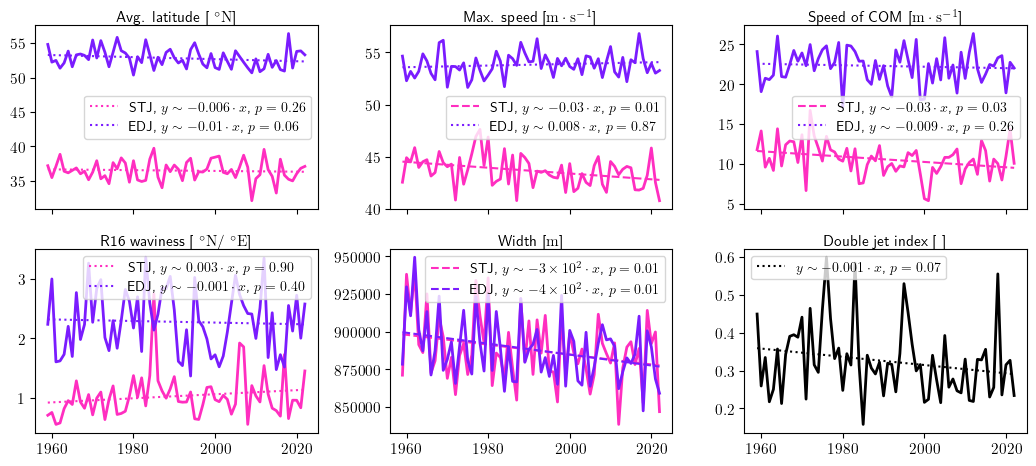

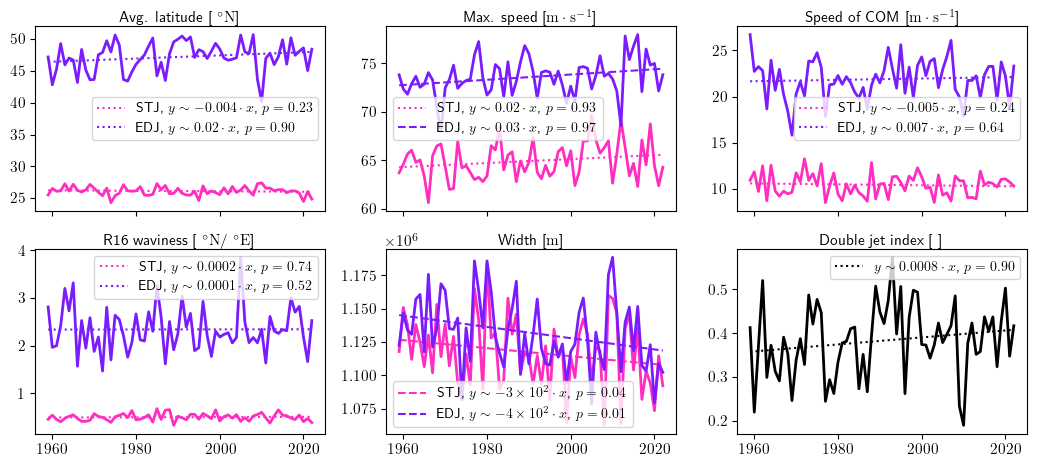

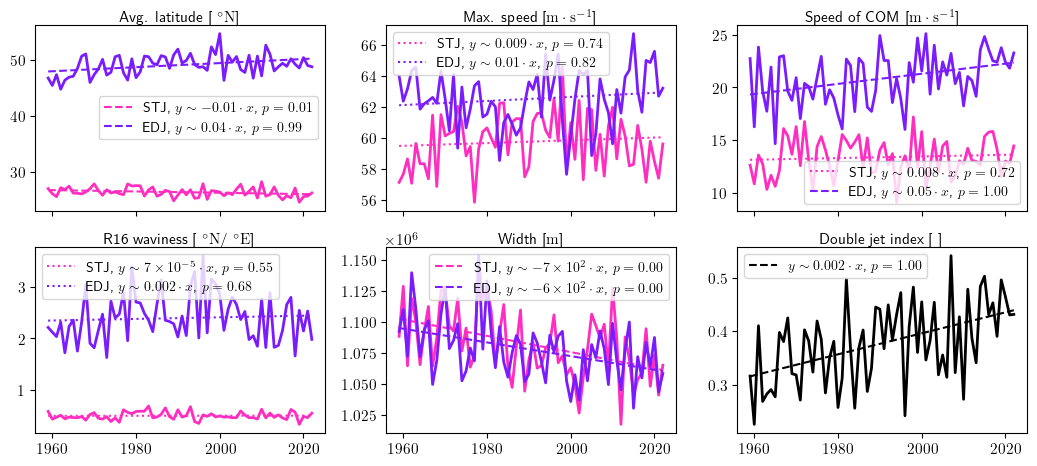

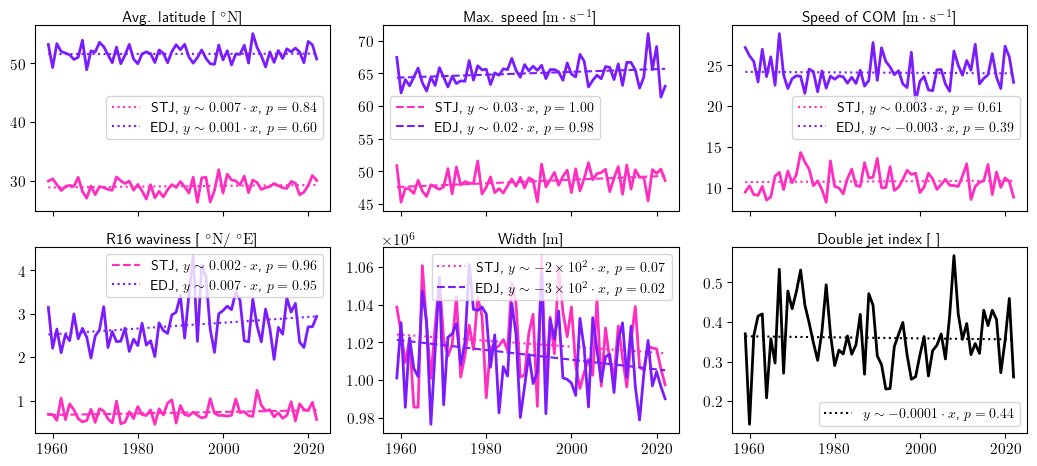

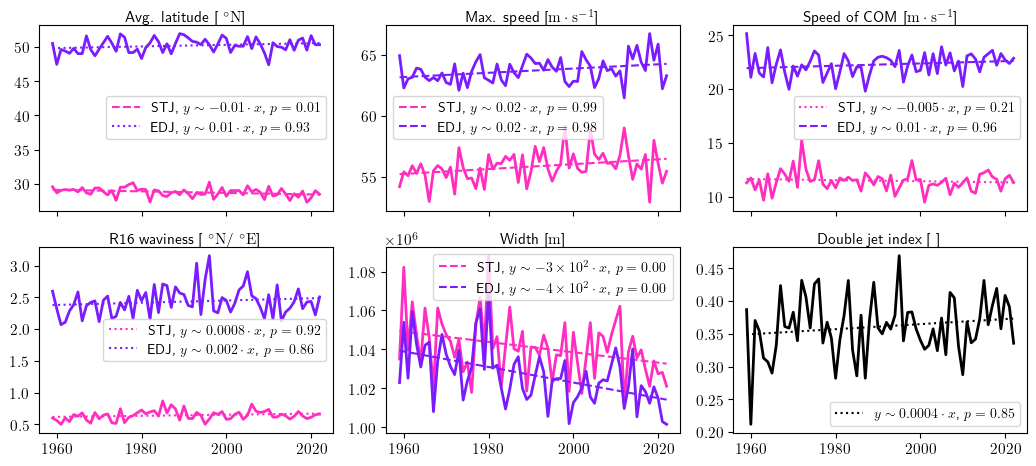

In [5]:
data_vars = [
    "mean_lat",
    "s_star",
    "com_speed",
    "wavinessR16",
    "width",
    "double_jet_index",
]
# for season in ["JJA"]:
for season in ["JJA", "DJF", "MAM", "SON", None]:
    plot_trends(
        data_vars, props_as_df, season, n_boostraps=1000, nrows=2, ncols=3, clear=False, suffix="_subset"
    )

In [7]:
# factors = {
#     "mean_lat": 0.001,
#     "spe_star": 0.01,
#     "com_speed": 0.001,
#     "wavinessR16": 0.0001,
#     "width": 1000,
#     "double_jet_index": 0.0001,
# }
factors = {
    "mean_lon": 0.001,
    "mean_lat": 0.001,
    "mean_lev": 0.01,
    "s_star": 0.01,
    "mean_s": 0.01,
    "tilt": 0.0001,
    "waviness1": 0.0001,
    "wavinessR16": 0.0001,
    "wavinessDC16": 0.0001,
    "wavinessFV15": 0.00001,
    "width": 1000,
    "int": 1e5,
    "int_over_europe": 1e5,
    "persistence": 0.001,
    "com_speed": 0.001,
    "double_jet_index": 0.0001,
}
data_vars = list(factors)
index_columns = get_index_columns(props_as_df, ("member", "time", "cluster", "jet"))
props_as_df_reduced = props_as_df.filter(pl.col("time").dt.year() >= 1979)
jets = ["STJ", "EDJ"]
seasons = list(SEASONS).copy()
seasons.append("Year")
periods = ["1959-", "1979-"]
iterables = [seasons, periods]
columns = pd.MultiIndex.from_product(iterables, names=["Season", "Period"])
iterables = [[PRETTIER_VARNAME[varname] for varname in data_vars], jets]
index = pd.MultiIndex.from_product(iterables, names=["Property", "Jet"])
df = pd.DataFrame(
    np.zeros((len(index), len(columns)), dtype="str"), index=index, columns=columns
)
for season in seasons:
    for reduced, period in zip([False, True], periods):
        if reduced:
            pads = props_as_df_reduced
        else:
            pads = props_as_df
        season_ = None if season == "Year" else season
        if season_ is not None:
            pads = pads.filter(pl.col("time").dt.month().is_in(SEASONS[season]))
        pads = (
            pads[[*index_columns, *data_vars]]
            .group_by([pl.col("time").dt.year(), pl.col("jet")], maintain_order=True)
            .mean()
        )
        x = pads["time"].unique().to_numpy()
        for varname, factor in factors.items():
            for jet in jets:
                try:
                    this_da = pads.filter(pl.col("jet") == jet)[varname]
                    c1, c0, _, p, _ = linregress(x, this_da.to_numpy())
                except KeyError:
                    this_da = pads[varname]
                    c1, c0, _, p, _ = linregress(x, this_da.to_numpy())
                with warnings.catch_warnings():
                    warnings.simplefilter(
                        "ignore", category=pd.errors.PerformanceWarning
                    )
                    indexer1 = ((PRETTIER_VARNAME[varname], jet), (season, period))
                    str_start = r"${" if p > 0.05 else r"$\mathbf{"
                    str_ = str_start + num2tex(c1 / factor, ncomma=2) + r"}$"
                    # df.loc[*indexer1] = f"{c1:.2f} ({p:.2f})"
                    df.loc[*indexer1] = str_
suffix = "_extended" if len(factors) > 6 else ""
df.to_latex(
    buf=f"persistent-extremes-era5/out{suffix}.tex",
    escape=False,
    column_format="l",
    multirow=False,
    header=True,
    index_names=False,
)

# Trends in Variability

In [8]:
data_vars = [
    "waviness1",
    "waviness2",
    "wavinessR16",
    "wavinessDC16",
    "wavinessFV15",
    "tilt",
]
for season in ["JJA", "DJF", "MAM", "SON", None]:
    plot_trends(
        data_vars,
        props_as_df,
        season,
        std=True,
        nrows=2,
        ncols=3,
        clear=True,
        suffix="_waviness",
    )

In [9]:
data_vars = [
    "mean_lon",
    "mean_lat",
    "mean_lev",
    "mean_s",
    "s_star",
    "tilt",
    "waviness1",
    "wavinessR16",
    "wavinessDC16",
    "wavinessFV15",
    "width",
    "int",
    "int_over_europe",
    "persistence",
    "com_speed",
    "double_jet_index",
]
for season in ["JJA", "DJF", "MAM", "SON", None]:
    plot_trends(data_vars, props_as_df, season, std=True, nrows=4, ncols=4, clear=True)

In [10]:
data_vars = [
    "mean_lat",
    "s_star",
    "com_speed",
    "wavinessR16",
    "width",
    "double_jet_index",
]
for season in ["JJA", "DJF", "MAM", "SON", None]:
    plot_trends(
        data_vars,
        props_as_df,
        season,
        std=True,
        nrows=2,
        ncols=3,
        clear=True,
        suffix="_subset",
    )

# Correlations

In [87]:
corr_mat = np.corrcoef(
    np.nan_to_num(
        props_as_df
        .filter(
            pl.col("jet") == "EDJ", 
            pl.col("time").dt.month().is_in([6, 7, 8])
        )
        .to_numpy()[:, 2:]
        .astype(float)
    ), 
    rowvar=False
)

In [90]:
exp_pvs = DataHandler.from_specs("ERA5", "surf", "pvs", "6H", "all", "JJA", -80, 40, 15, 80, 250, "hourofyear", {"hourofyear": ("win", 60)})
da_pvs = exp_pvs.da.load()

In [16]:
season_mask = props_as_ds.time.dt.season == "JJA"
props_as_ds_late = props_as_ds.sel(time=season_mask)
props_as_ds_late["anti_pv_activity"] = da_pvs.sel(type="anti").sum(dim=["lon", "lat"])
props_as_ds_late["cycl_pv_activity"] = da_pvs.sel(type="cycl").sum(dim=["lon", "lat"])
cmap = colormaps.BlWhRe
norm = BoundaryNorm(np.delete(np.arange(-1, 1.1, 0.2), 5), cmap.N)

In [17]:
to_concat = []
polar_valids = ~props_as_ds_late["mean_lon"].sel(jet="polar").isnull().values
for varname, da in props_as_ds_late.items():
    if varname not in [
        "anti_pv_activity",
        "cycl_pv_activity",
        "overlap",
        "vert_dist",
        "n_jets",
        "nao",
        "double_jet_index",
    ]:
        to_concat.append(
            da.sel(jet="polar")
            .fillna(DEFAULT_VALUES.get(varname, 0))
            .values[polar_valids]
        )
    else:
        to_concat.append(da.fillna(0).values[polar_valids])
fig, ax = plt.subplots(figsize=(7, 6.5))
im = plt.imshow(np.corrcoef(np.stack(to_concat)), cmap=cmap, norm=norm)
plt.colorbar(im, spacing="proportional")
ax.set_yticks(np.arange(0, len(props_as_ds_late.data_vars)), props_as_ds_late.data_vars)
_ = ax.set_xticks(
    np.arange(0, len(props_as_ds_late.data_vars)),
    props_as_ds_late.data_vars,
    rotation=45,
    ha="right",
)
ax.set_title("EDJ")
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_corr_polar.png")

In [18]:
to_concat = []
polar_valids = ~props_as_ds_late["mean_lon"].sel(jet="subtropical").isnull().values
for varname, da in props_as_ds_late.items():
    if varname not in [
        "anti_pv_activity",
        "cycl_pv_activity",
        "overlap",
        "vert_dist",
        "n_jets",
        "nao",
        "double_jet_index",
    ]:
        to_concat.append(
            da.sel(jet="subtropical")
            .fillna(DEFAULT_VALUES.get(varname, 0))
            .values[polar_valids]
        )
    else:
        to_concat.append(da.fillna(0).values[polar_valids])
fig, ax = plt.subplots(figsize=(7, 6.5))
im = plt.imshow(np.corrcoef(np.stack(to_concat)), cmap=cmap, norm=norm)
plt.colorbar(im, spacing="proportional")
ax.set_yticks(np.arange(0, len(props_as_ds_late.data_vars)), props_as_ds_late.data_vars)
_ = ax.set_xticks(
    np.arange(0, len(props_as_ds_late.data_vars)),
    props_as_ds_late.data_vars,
    rotation=45,
    ha="right",
)
ax.set_title("STJ")
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_corr_subtropical.png")

In [19]:
to_concat = []
ticks = []
valids = props_as_ds_late["mean_lon"]
valids = (
    ~valids.sel(jet="polar").isnull() & ~valids.sel(jet="subtropical").isnull()
).values
for varname, da in props_as_ds_late.items():
    if varname not in [
        "anti_pv_activity",
        "cycl_pv_activity",
        "overlap",
        "vert_dist",
        "n_jets",
        "nao",
        "double_jet_index",
    ]:
        for jet in da.jet.values:
            to_concat.append(
                da.sel(jet=jet).fillna(DEFAULT_VALUES.get(varname, 0)).values[valids]
            )
            ticks.append(f"{varname}, {SHORTHAND[jet]}")
    else:
        to_concat.append(np.roll(da.fillna(0).values[valids], 0))
        ticks.append(varname)
fig, ax = plt.subplots(figsize=(13, 10))
im = plt.pcolormesh(
    np.corrcoef(np.stack(to_concat)),
    cmap=cmap,
    norm=norm,
    lw=0.01,
    edgecolors="lightgrey",
)
plt.colorbar(im, spacing="proportional", drawedges=True)
ax.invert_yaxis()
ax.set_yticks(np.arange(0.5, len(ticks) + 0.5), ticks)
_ = ax.set_xticks(np.arange(0.5, len(ticks) + 0.5), ticks, rotation=45, ha="right")
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_corr_full.png")

In [20]:
to_concat = []
ticks = []
freq = "1W"
this_pads = props_as_ds_late.resample(time=freq).mean()
valids = this_pads["mean_lon"]
valids = (
    ~valids.sel(jet="polar").isnull() & ~valids.sel(jet="subtropical").isnull()
).values
for varname, da in this_pads.items():
    if varname not in [
        "anti_pv_activity",
        "cycl_pv_activity",
        "overlap",
        "vert_dist",
        "n_jets",
        "nao",
        "double_jet_index",
    ]:
        for jet in da.jet.values:
            to_concat.append(
                da.sel(jet=jet).fillna(DEFAULT_VALUES.get(varname, 0)).values[valids]
            )
            ticks.append(f"{varname}, {SHORTHAND[jet]}")
    else:
        to_concat.append(np.roll(da.fillna(0).values[valids], 0))
        ticks.append(varname)
fig, ax = plt.subplots(figsize=(13, 10))
im = plt.pcolormesh(
    np.corrcoef(np.stack(to_concat)),
    cmap=cmap,
    norm=norm,
    lw=0.01,
    edgecolors="lightgrey",
)
plt.colorbar(im, spacing="proportional", drawedges=True)
ax.invert_yaxis()
ax.set_yticks(np.arange(0.5, len(ticks) + 0.5), ticks)
_ = ax.set_xticks(np.arange(0.5, len(ticks) + 0.5), ticks, rotation=45, ha="right")
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_corr_full_{freq}.png")

In [21]:
to_concat = []
ticks = []
freq = "1ME"
this_pads = props_as_ds_late.resample(time=freq).mean()
valids = this_pads["mean_lon"]
valids = (
    ~valids.sel(jet="polar").isnull() & ~valids.sel(jet="subtropical").isnull()
).values
for varname, da in this_pads.items():
    if varname not in [
        "anti_pv_activity",
        "cycl_pv_activity",
        "overlap",
        "vert_dist",
        "n_jets",
        "nao",
        "double_jet_index",
    ]:
        for jet in da.jet.values:
            to_concat.append(
                da.sel(jet=jet).fillna(DEFAULT_VALUES.get(varname, 0)).values[valids]
            )
            ticks.append(f"{varname}, {SHORTHAND[jet]}")
    else:
        to_concat.append(np.roll(da.fillna(0).values[valids], 0))
        ticks.append(varname)
fig, ax = plt.subplots(figsize=(13, 10))
im = plt.pcolormesh(
    np.corrcoef(np.stack(to_concat)),
    cmap=cmap,
    norm=norm,
    lw=0.01,
    edgecolors="lightgrey",
)
plt.colorbar(im, spacing="proportional", drawedges=True)
ax.invert_yaxis()
ax.set_yticks(np.arange(0.5, len(ticks) + 0.5), ticks)
_ = ax.set_xticks(np.arange(0.5, len(ticks) + 0.5), ticks, rotation=45, ha="right")
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_corr_full_{freq}.png")

In [22]:
to_concat = []
ticks = []
freq = "1YE"
this_pads = props_as_ds_late.resample(time=freq).mean()
valids = this_pads["mean_lon"]
valids = (
    ~valids.sel(jet="polar").isnull() & ~valids.sel(jet="subtropical").isnull()
).values
for varname, da in this_pads.items():
    if varname not in [
        "anti_pv_activity",
        "cycl_pv_activity",
        "overlap",
        "vert_dist",
        "n_jets",
        "nao",
        "double_jet_index",
    ]:
        for jet in da.jet.values:
            to_concat.append(
                da.sel(jet=jet).fillna(DEFAULT_VALUES.get(varname, 0)).values[valids]
            )
            ticks.append(f"{varname}, {SHORTHAND[jet]}")
    else:
        to_concat.append(np.roll(da.fillna(0).values[valids], 0))
        ticks.append(varname)
fig, ax = plt.subplots(figsize=(13, 10))
im = plt.pcolormesh(
    np.corrcoef(np.stack(to_concat)),
    cmap=cmap,
    norm=norm,
    lw=0.01,
    edgecolors="lightgrey",
)
plt.colorbar(im, spacing="proportional", drawedges=True)
ax.invert_yaxis()
ax.set_yticks(np.arange(0.5, len(ticks) + 0.5), ticks)
_ = ax.set_xticks(np.arange(0.5, len(ticks) + 0.5), ticks, rotation=45, ha="right")
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_corr_full_{freq}.png")

# Seasonal variability ?

In [ ]:
def periodic_rolling(df: pl.DataFrame, dim: str, other_dims: Sequence[str], winsize: int, data_vars: list):
    df = df.cast({dim: pl.Int32})
    halfwinsize = winsize // 2
    other_columns = get_index_columns(df, other_dims)
    descending = [False, *[col == "jet" for col in other_columns]]
    len_ = [df[col].unique().len() for col in other_columns]
    len_ = np.prod(len_)
    max_along_dim = df[dim].max()
    df = df.sort([dim, *other_columns], descending=descending)
    df = pl.concat(
        [
            df.tail(halfwinsize * len_).with_columns(pl.col(dim) - max_along_dim),
            df,
            df.head(halfwinsize * len_).with_columns(pl.col(dim) + max_along_dim),
        ]
    )
    df = df.rolling(
        pl.col(dim),
        period=f"{winsize}i",
        offset=f"-{halfwinsize + 1}i",
        group_by=other_columns,
    ).agg(*[pl.col(col).mean() for col in data_vars])
    df = df.sort([dim, *other_columns], descending=descending)
    df = df.slice(halfwinsize * len_, max_along_dim * len_)
    return df

In [63]:
def periodic_rolling(df: pl.DataFrame, winsize: int, data_vars: list):
    df = df.cast({"dayofyear": pl.Int32})
    halfwinsize = winsize // 2
    other_columns = get_index_columns(df, ("member", "jet"))
    descending = [False, *[col == "jet" for col in other_columns]]
    len_ = [df[col].unique().len() for col in other_columns]
    len_ = np.prod(len_)
    max_doy = df["dayofyear"].max()
    df = df.sort(["dayofyear", *other_columns], descending=descending)
    df = pl.concat(
        [
            df.tail(halfwinsize * len_).with_columns(pl.col("dayofyear") - max_doy),
            df,
            df.head(halfwinsize * len_).with_columns(pl.col("dayofyear") + max_doy),
        ]
    )
    df = df.rolling(
        pl.col("dayofyear"),
        period=f"{winsize}i",
        offset=f"-{halfwinsize + 1}i",
        group_by=other_columns,
    ).agg(*[pl.col(col).mean() for col in data_vars])
    df = df.sort(["dayofyear", *other_columns], descending=descending)
    df = df.slice(halfwinsize * len_, max_doy * len_)
    return df

In [10]:
from matplotlib.dates import DateFormatter, MonthLocator


def plot_seasonal(
    data_vars: list,
    props_as_df: pl.DataFrame,
    nrows: int = 3,
    ncols: int = 4,
    clear: bool = True,
    suffix: str = "",
):
    if clear:
        plt.ioff()
    else:
        plt.ion()
        plt.show()
        clear_output()
    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=(ncols * 3.5, nrows * 2.4),
        tight_layout=True,
        sharex="all",
    )
    axes = axes.flatten()
    jets = props_as_df["jet"].unique().to_numpy()
    gb = props_as_df.group_by(
        [pl.col("time").dt.ordinal_day().alias("dayofyear"), pl.col("jet")], maintain_order=True
    )
    means = periodic_rolling(means, 15, data_vars)
    x = means["dayofyear"].unique()
    medians = periodic_rolling(medians, 15, data_vars)
    q025 = gb.quantile(0.25)
    q075 = gb.quantile(0.75)
    for varname, ax in zip(data_vars, axes.ravel()):
        dji = varname == "double_jet_index"
        ys = means[varname].to_numpy().reshape(366, 2)
        qs = np.stack(
            [
                q025[varname].to_numpy().reshape(366, 2),
                q075[varname].to_numpy().reshape(366, 2),
            ],
            axis=2,
        )
        median = medians[varname].to_numpy().reshape(366, 2)
        for i in range(2):
            color = "black" if dji else COLORS[2 - i]
            ax.fill_between(
                x, qs[:, i, 0], qs[:, i, 1], color=color, alpha=0.2, zorder=-10
            )
            ax.plot(x, median[:, i], lw=2, color=color, ls="dotted", zorder=0)
            ax.plot(x, ys[:, i], lw=3, color=color, label=jets[i], zorder=10)
            if dji:
                break
        ax.set_title(
            f"{PRETTIER_VARNAME.get(varname, varname)} [{UNITS.get(varname, '')}]"
        )
        ax.xaxis.set_major_locator(MonthLocator(range(0, 13, 3)))
        ax.xaxis.set_major_formatter(DateFormatter("%b"))
        ax.set_xlim(min(x), max(x))
        if varname == "mean_lev":
            ax.invert_yaxis()
        ylim = ax.get_ylim()
        # wherex = np.isin(x.month, [6, 7, 8])
        # ax.fill_between(x, *ylim, where=wherex, alpha=0.1, color="black", zorder=-10)
        ax.set_ylim(ylim)
    axes.ravel()[0].legend().set_zorder(102)
    plt.savefig(f"{FIGURES}/jet_props_misc/jet_props_seasonal{suffix}.png")
    if clear:
        del fig
        plt.close()
        clear_output()

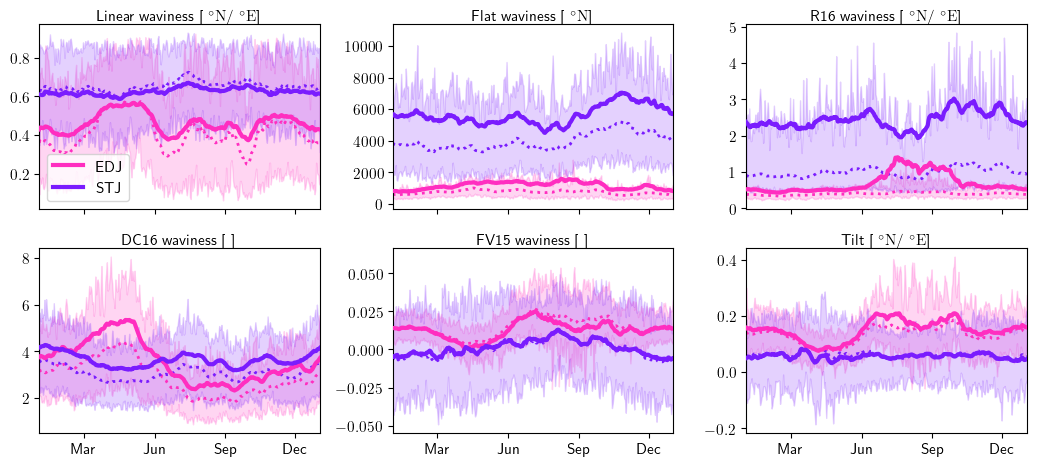

In [11]:
data_vars = [
    "waviness1",
    "waviness2",
    "wavinessR16",
    "wavinessDC16",
    "wavinessFV15",
    "tilt",
]
plot_seasonal(data_vars, props_as_df, nrows=2, ncols=3, clear=False, suffix="_waviness")

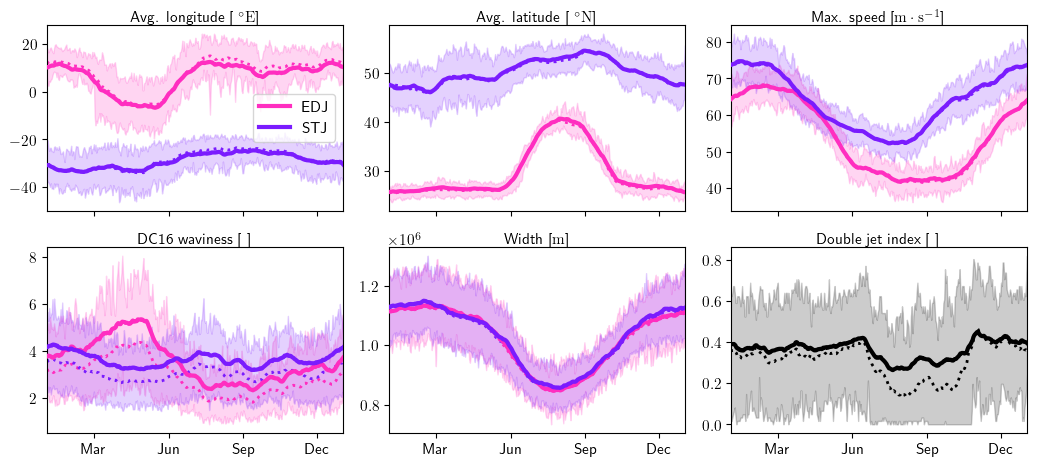

In [12]:
data_vars = [
    "mean_lon",
    "mean_lat",
    "s_star",
    "wavinessDC16",
    "width",
    "double_jet_index",
]
plot_seasonal(data_vars, props_as_df, nrows=2, ncols=3, clear=False, suffix="_subset")

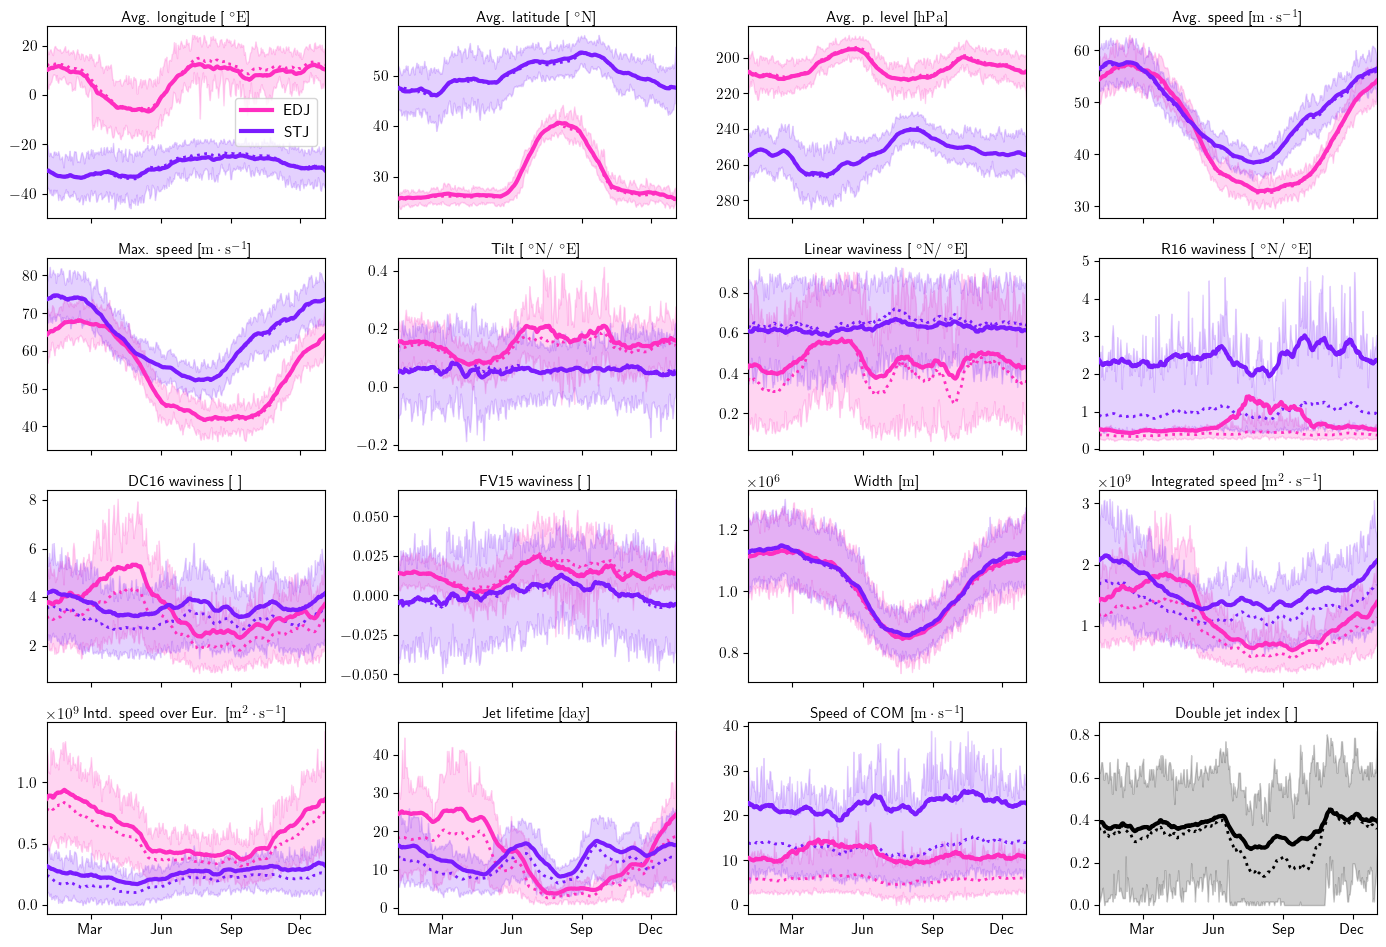

In [13]:
data_vars = [
    "mean_lon",
    "mean_lat",
    "mean_lev",
    "mean_s",
    "s_star",
    "tilt",
    "waviness1",
    "wavinessR16",
    "wavinessDC16",
    "wavinessFV15",
    "width",
    "int",
    "int_over_europe",
    "persistence",
    "com_speed",
    "double_jet_index",
]
plot_seasonal(data_vars, props_as_df, nrows=4, ncols=4, clear=False)

# Dayofyear trend

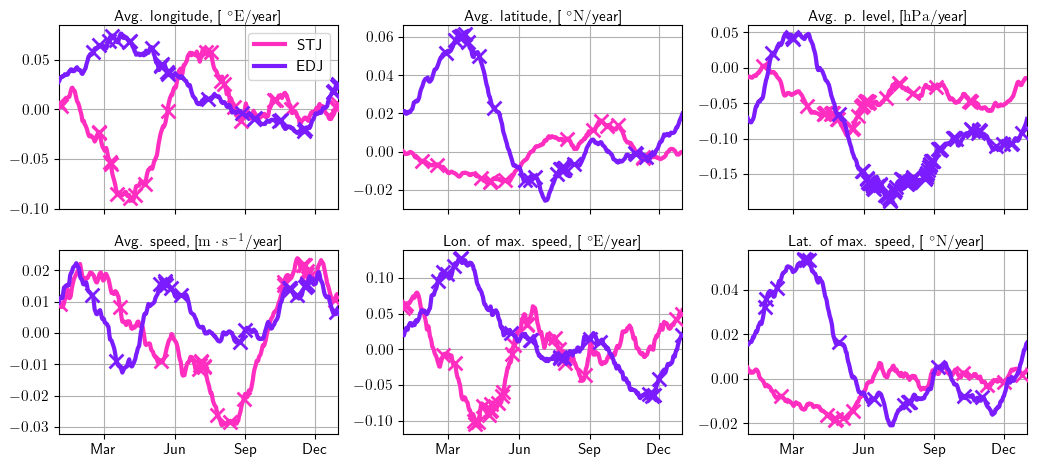

In [70]:
from matplotlib.dates import DateFormatter, MonthLocator

data_vars = [
    "mean_lon",
    "mean_lat",
    "s_star",
    "wavinessDC16",
    "width",
    "double_jet_index",
]
nrows = 2
ncols = 3
winsize = 60
fig, axes = plt.subplots(
    nrows, ncols, figsize=(ncols * 3.5, nrows * 2.4), tight_layout=True, sharex="all"
)
axes = axes.flatten()

n_years = props_as_df["time"].dt.year().n_unique()
rng = np.random.default_rng()
n_bootstraps = 500
bootstrap_len = 4
num_blocks = n_years // bootstrap_len

sample_indices = rng.choice(n_years - bootstrap_len - 1, size=(n_bootstraps, n_years // bootstrap_len))
sample_indices = sample_indices[..., None] + np.arange(bootstrap_len)[None, None, :]
sample_indices = sample_indices.reshape(n_bootstraps, num_blocks * bootstrap_len)
sample_indices = np.append(sample_indices, np.arange(n_years)[None, :], axis=0)
sample_indices = sample_indices.flatten()

data_vars = [col for col in props_as_df.columns if col not in ["time", "jet", "year", "flag"]]
props_as_df_daily = props_as_df.group_by_dynamic(pl.col("time"), every="1d", group_by="jet").agg(**{data_var: pl.col(data_var).mean() for data_var in data_vars}).sort([pl.col("time"), pl.col("jet")])
props_as_df_daily = props_as_df_daily.filter(pl.col("time").dt.ordinal_day() < 366)
ts_bootstrapped = props_as_df_daily.group_by([pl.col("time").dt.ordinal_day().alias("dayofyear"), pl.col("jet")], maintain_order=True).agg(
    **{data_var: pl.col(data_var).gather(sample_indices) for data_var in data_vars}, 
    year=pl.col("time").dt.year().gather(sample_indices), 
    inside_index=pl.int_range(len(sample_indices)) % 64,
    sample_index=pl.int_range(len(sample_indices)) // 64,
).explode([*data_vars, "year", "inside_index", "sample_index"])
slopes = ts_bootstrapped.group_by(["dayofyear", "sample_index", "jet"], maintain_order=True).agg(**{data_var: pl.col(data_var).least_squares.ols(pl.col("inside_index"), mode="coefficients", add_intercept=True, null_policy="drop").struct.field("inside_index") for data_var in data_vars})
pvals = slopes.group_by(["dayofyear", "jet"], maintain_order=True).agg(**{data_var: pl.col(data_var).head(n_bootstraps).sort().search_sorted(pl.col(data_var).get(-1)) / n_bootstraps for data_var in data_vars})

ys = slopes.filter(pl.col("sample_index") == n_bootstraps)
ys = periodic_rolling(ys, winsize, data_vars)

for varname, ax in zip(data_vars, axes.ravel()):
    dji = varname == "double_jet_index"
    if varname == "mean_lev":
        ax.invert_yaxis()
    ax.set_title(
        f"{PRETTIER_VARNAME.get(varname, varname)} [{UNITS.get(varname, '')}]"
    )
    dji = varname == "double_jet_index"
    for i, jet in enumerate(["STJ", "EDJ"]):
        color = "black" if dji else COLORS[2 - i]
        y = ys.filter(pl.col("jet") == jet)[varname]
        ps = pvals.filter(pl.col("jet") == jet)[varname]
        x = np.arange(len(y))
        ax.plot(x, y, lw=3, color=color, label=jet, zorder=10)
        filter_ = (ps > 0.975) | (ps < 0.025)
        ax.scatter(
            x[filter_],
            y.filter(filter_),
            marker="x",
            color=color,
            s=100,
            linewidths=2,
            zorder=10,
        )
        if dji:
            break
    ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS.get(varname, '1')}/year]")
    ax.xaxis.set_major_locator(MonthLocator(range(0, 13, 3)))
    ax.xaxis.set_major_formatter(DateFormatter("%b"))
    ax.set_xlim(min(x), max(x))
    if varname == "mean_lev":
        ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim)
    ax.grid(True)
axes.ravel()[0].legend().set_zorder(102)
plt.savefig(f"{FIGURES}/jet_props_misc/dayofyear_trends_{winsize=}.png")